The purpose of this notebook is to show how the validity of different models can be assessed when fit to a dataset. A dataset related to the activity as a function of time for a radioactive isotope was imported, and two models were fit to the data. One model assumes a single isotope is present in the sample, and the other assumes two isotopes. The criteria used to assess each model are the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC), with lower values indicating a better model. 

Different methods of estimating uncertainties in model parameters are also investigated, including the chi-squared grid method and the MCMC method (Metropolis-Hastings algorithm). The chi-squared grid method is used to create an N-dimensional grid of chi-squared values as a function of different combinations of model parameter, where N is the number of parameters. The combination providing the lowest chi-squared value is the set of best fit parameters, and uncertainties are taken as a confidence interval. Confidence intervals are determined by fixing one parameter at its best fit value, and varying the other until the chi-squared value increases by a certain amount. For example, if one parameter is fixed and the other is varied unti the chi-squared value increases by 6.17, the 95% confidence interval in the varied parameter is given by +/- this variation. This method was used for the single isotope model as there are only 2 parameters (Initial activity and decay constant). For larger values of N, the chi-squared grid becomes computationally heavy, so the MCMC method was used for the dual isotope model where N = 4.

The MCMC method uses an algorithm to sample from complex probability distributions and can enable efficient exploration of high-dimensional spaces. It is useful in Bayesian statistics where it can approximate the posterior distribution of model parameters given the observed data. The idea is to construct a Markov chain that iteratively explores parameter space such that the stationary distribution of the chain converges upon the posterior distribution. Briefly, the steps involved in the Metropolis-Hastings algorithm include providing an initial guess of models parameters. A likelihood function is defined to evaluate the probability of observing the experimental data based on a model incorporating said parameters, in this case the chi-squared statistic was calculated to assess likelihood.  A new set of parameters is proposed using a predefined proposal function. The likelihood of observing the experimental data with the new parameters is calculated. If this likelihood is higher, a new set of parameters is proposed and the chain jumps to a new location. Otherwise, the probability of jumping to a new position is set by the proposal function. A random number is selected between 0 and 1 and if it is higher than this probability, the chain will jump to a new position, otherwise it remains in place until the next iteration where the process repeats. This enables the chain to spend the majority of its time in locations with high likelihood, whilst still exploring areas with lower likelihoods. These steps are repeated a large number to times until the distribution converges. Statistics such as the mean or median of sampled parameters can be calculated to estimate best fit parameters, with suitable confidence intervals serving as uncertainties.

In [1]:
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

file_path = 
data = np.loadtxt(file_path, dtype = float)

x_data = data[:, 0]
time_interval = x_data[1] - x_data[0]

y1_raw = data[:, 1]/time_interval
y1_data = np.log(y1_raw)
y1_error_raw = data[:, 2]/time_interval
y1_error = y1_error_raw/y1_raw

In [2]:
#CONSTANTS
#All quantities are in standard units

#Difference in chi squared values corresponding to 68, 95, 99% confidence intervals
CI_68 = 2.3
CI_95 = 6.17
CI_99 = 11.8

CI = CI_99 #Change to CI_68 or CI_95 to vary confidence intervals

#Initial Guesses for two isotope scipy fit - May need to be adjusted for different Data
initial_guess1 = [1000, 0.036, 2000, 0.014]
initial_guess2 = [200, 0.036, 500, 0.014]
initial_guess3 = [50, 0.036, 150, 0.014]
initial_guess4 = [12, 0.036, 80, 0.014]

#Step number and initial parameters for MCMC - May need to be adjusted for different Data to achieve suitable jump fractions
step_number = 250000
initial_pars1 = np.array([1000, 0.03, 2000, 0.004])
initial_pars2 = np.array([200, 0.04, 500, 0.005])
initial_pars3 = np.array([50, 0.06, 200, 0.006])
initial_pars4 = np.array([20, 0.05, 60, 0.005])

#Step sizes for MCMC
step1 = np.array([15, 0.001, 15, 0.0001])
step2 = np.array([10, 0.001, 10, 0.0001])
step3 = np.array([8, 0.001, 8, 0.0001])
step4 = np.array([4, 0.001, 4, 0.0001])

#Parameters, Data points and Degrees of freedom for AIC and BIC calculations
N = 100
param = 2 #Parameters for one isotope model
param2 = 4 #Parameters for two isotope model
dof = N - param #DOF for one isotope model
dof2 = N - param2 # DOF for two isotope model

#Isotope Half Lives
Cs_120 = 61.2
Cs_121 = 154.8
Cs_124 = 30.9
Ba_123 = 162
Ba_124 = 660
Ba_125 = 210
Ba_137 = 153.1
Eu_137 = 8.4
Eu_138 = 12.1
Eu_139 = 17.9
Eu_143 = 155.4
W_166 = 19.2
W_168 = 51
W_169 = 76.2
Np_229 = 240
Np_230 = 276
Np_232 = 882

A number of constants are defined to be used later including:
- The change in chi-squared value corresponding to different confidence intervals for parameters in a 2 parameter model.
- An initial guess for parameters in the dual isotope model to be used for the scipy fit.
- An initial guess for the MCMC method.
- Step sizes for the MCMC method
- Half-lives for some candidate isotopes from which the unknown sample will be identified.

In [3]:
#FUNCTIONS

#Input data, gradient and intercept to return linear fit
def linear(m, x, c):
    return m*x + c

#Input data, initial activity and decay constant to return exponential fit
def exp1(x, A1, lambda1):
    return A1*np.exp(-lambda1*x)

#Two isotope exponential fit
def exp2(x, A1, lambda1, A2, lambda2):
    return A1*np.exp(-lambda1*x) + A2*np.exp(-lambda2*x)

#Two isotope model used for MCMC simulation
def exp2m(x, parameters):
    return parameters[0]*np.exp(-parameters[1]*x) + parameters[2]*np.exp(-parameters[3]*x)

#Input x, y data and errors to return sums used in least squares fit
def chi_sums(x_data, y_data, error):
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    error = np.array(error)
    
    inv_y_error2 = 1/(error*error)
    S = np.sum(inv_y_error2)
    x = x_data * inv_y_error2
    y = y_data * inv_y_error2
    xy = x_data * y_data * inv_y_error2
    xx = x_data * x_data * inv_y_error2
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(xy)
    sum_xx = np.sum(xx)
    
    return S, sum_x, sum_y, sum_xx, sum_xy

#Function to input sums from chi_sums to return gradient for least squares fit
def grad(S, sum_x, sum_y, sum_xx, sum_xy):
    gradient = (S*sum_xy - sum_x*sum_y)/(S*sum_xx - sum_x*sum_x)
    return gradient

#Function to input sums from chi_sums to return intercept for least squares fit
def intercept(S, sum_x, sum_y, sum_xx, sum_xy):
    intercept = (sum_xx*sum_y - sum_x*sum_xy)/(S*sum_xx - sum_x*sum_x)
    return intercept

#Function to input data, fit and errors to return chi squared value
def chi2(data, fit, error):
    x = ((data-fit)**2)/error**2
    chi = np.sum(x)
    return chi

#Function to input chi squared and degrees of freedom to return reduced chi squared
def chi_reduced(chi, dof):
    return chi/dof

#Function to input x, y data, gradient range, intercept range, errors and resolution to return a 2 x 2 grid of chi squared values
#Resolution is the number of m and c values to iterate through
def chi_grid(x, y, m_min, m_max, c_min, c_max, error, resolution):
    m_list = np.linspace(m_min, m_max, resolution) #Range of gradients to iterate over
    c_list = np.linspace(c_min, c_max, resolution) #Range of intercepts to iterate over
    chi2_list = [] #list to hold chi squared values
    
    for m in m_list:
        for c in c_list: #Nested for loop to iterate through every intercept value for each gradient value in m_list
            fit = linear(m, x, c) #Apply a linear fit to the data with corresponding gradient and intercept
            chi2_val = chi2(y, fit, error) #Calculate corresponding chi squared value
            chi2_list.append(chi2_val) #Append chi squared value to list
            #print(f"m: {m}, c: {c}, chi2_val: {chi2_val}")
            
    chi2_grid = np.array(chi2_list).reshape(len(c_list), len(m_list)) #Reshape the chi squared list into a grid of size m_list x c_list
    return m_list, c_list, chi2_list, chi2_grid 

#Function to fix intercept, iterate over a range of gradients and return corresponding chi squared values
def chi_c_fixed(x, y, error, m_min, m_max, fixed_c, resolution):
    varying_m = np.linspace(m_min, m_max, resolution)
    chi2_varying_m = []
    for m in varying_m:
        fit = linear(m, x, fixed_c)
        chi2_val_m = chi2(y, fit, error)
        chi2_varying_m.append(chi2_val_m)
    return varying_m, chi2_varying_m

#Function to fix gradient, iterate over a range of intercepts and return corresponding chi squared values
def chi_m_fixed(x, y, error, c_min, c_max, fixed_m, resolution):
    varying_c = np.linspace(c_min, c_max, resolution)
    chi2_varying_c = []
    for c in varying_c:
        fit = linear(fixed_m, x, c)
        chi2_val_c = chi2(y, fit, error)
        chi2_varying_c.append(chi2_val_c)
    return varying_c, chi2_varying_c

#Function to implement MCMC simulation and estimate best fit parameters
def mcmc(func, x, y, sig, pars0, stepsize, nstep=1e4):
    nstep=int(nstep)
    npars=pars0.shape[0]
    chain=np.zeros((int(nstep),npars))
    chi2=np.zeros(int(nstep))

    chain[0,:]=pars0.copy() #Chain initialized with defined parameters
    mdl=func(x,pars0) #Fit is determined based on initial parameters and a specified function
    chi2[0]=np.sum( (y-mdl)**2/sig**2) #Chi Squared value for the initial fit is calculated
    njump=0
    for i in range(1,nstep):
        pars_new=np.random.normal(chain[i-1,:],stepsize) #New set of parameters are chosen
        mdl=func(x,pars_new) #New fit is determined based on new parameters
        chi2_new=np.sum( (y-mdl)**2/sig**2) #New chi squared value is calculated
        if (chi2_new > chi2[i-1]):
            p0=np.exp(-(chi2_new-chi2[i-1])/2.) #If new chi squared is higher than previous, the jump probability is set by this function
            p=np.random.uniform(0,1,1) #Random value is selected between 0 and 1, if this random value is less than the previously calculated jump probability, new parameters are selected and the chain jumps
            if  p<=p0:
                chain[i,:]=pars_new
                chi2[i]=chi2_new
                njump=njump+1
            else:
                chain[i,:]=chain[i-1,:] #Otherwise the chain remains in place until the next iteration
                chi2[i]=chi2[i-1]
        else:
            chain[i,:]=pars_new #If the new chi squared value is lower than previous, the chain jumps immediately
            njump=njump+1
            chi2[i]=chi2_new
    print('Jump fraction: %.3f' %(njump/nstep))
    return chain  #sampled parameters during the simulation are returned

#Function to input x data, y data, errors, an initial fit, residuals and iterations to bootstrap gradients and intercepts
#Mean with standard deviations and Median gradients + intercepts are returned
def bootstrap(x_data, y_data, error, initial_fit, initial_resids, iterations):
    
    m_new_list = []
    c_new_list = []
    
    for i in np.arange(1, iterations, 1):
        indices = random.sample(range(0, len(x_data)), k = len(x_data)) #Random numbers selected from list of consecutive numbers ranging from 0 to len(x_data)
        res_sample = [initial_resids[a] for a in indices] #Residuals selected from initial residual list at indices within the indices list
        error = [error[a] for a in indices] #Corresponding errors at same indices selected and held in list
        
        new_fit = initial_fit + res_sample #New fit generated from initial fit + new residuals
        
        S, sum_x, sum_y, sum_xx, sum_xy = chi_sums(x_data, new_fit, error) #New chi sums calculated
        
        m_new = grad(S, sum_x, sum_y, sum_xx, sum_xy) #Corresponding gradient and intercepts calculated
        c_new = intercept(S, sum_x, sum_y, sum_xx, sum_xy)
        
        m_new_list.append(m_new) #Gradients and Intercepts appended to lists
        c_new_list.append(c_new)
    
    #Various statistics calculated from gradient and intercept lists
    mean_m = statistics.mean(m_new_list)
    median_m = statistics.median(m_new_list)
    std_m = statistics.stdev(m_new_list)

    mean_c = statistics.mean(c_new_list)
    median_c = statistics.median(c_new_list)
    std_c = statistics.stdev(c_new_list)
    
    return mean_m, median_m, std_m, mean_c, median_c, std_c, m_new_list, c_new_list

#Function to calculate AIC
def AIC(chi, parameters):
    return chi + 2*parameters

#Function to calculate BIC
def BIC(chi, parameters, N):
    return chi + np.log(N)*parameters

#Function to calculate AIC corrected
def AIC_corr(chi, parameters, N):
    return chi + 2*parameters + (2*parameters*(parameters + 1))/(N - parameters - 1)

A number of functions are defined. The main ones are chi_grid which is used to create a 2 x 2 grid of chi squared values as a function of different combinations of model parameters for the single isotope fit, chi_m_fixed and chi_c_fixed which fix one parameter and vary the other returning corresponding chi-squared values, mcmc which returns the list parameters sampled by the algorithm for the dual isotope model and various functions to calculate the AIC and BIC values.

In [4]:
#FUNCTIONS - DATASET PROCESSING - Previous functions are combined with commands to return salient data and help reduce redundancy

#Function to perform chi squared fit on dataset with errors and return gradient, intercept, residuals and chi squared value
def perform_chi_square_fit(x_data, y_data, y_error):
    S, sum_x, sum_y, sum_xx, sum_xy = chi_sums(x_data, y_data, y_error)
    m = grad(S, sum_x, sum_y, sum_xx, sum_xy)
    c = intercept(S, sum_x, sum_y, sum_xx, sum_xy)
    fit = linear(m, x_data, c)
    residuals = fit - y_data
    chi_square = chi2(y_data, fit, y_error)
    
    return m, c, fit, residuals, chi_square

#Function to return optimal fit parameters using the chi squared grid
def find_optimal_parameters(x_data, y_data, error, m_min, m_max, c_min, c_max, resolution):
    m_list, c_list, chi2_list, chi2_grid = chi_grid(x_data, y_data, m_min, m_max, c_min, c_max, error, resolution)
    min_chi2 = min(chi2_list)
    min_chi2_index = np.argmin(chi2_list)
    min_chi2_value = chi2_list[min_chi2_index]
    m_index, c_index = np.unravel_index(min_chi2_index, chi2_grid.shape)
    
    return m_list, c_list, chi2_list, chi2_grid, min_chi2, min_chi2_index, min_chi2_value, m_index, c_index

def generate_one_isotope_fit(x_data, best_fit_m, best_fit_c):
    return exp1(x_data, np.exp(best_fit_c), -best_fit_m)

#Function to return chi squared values for varying intercepts or gradients while the other is fixed
#Parameter type is selected beforehand, either m or c, to determine which will be fixed and which to iterate over
def chi_squared_fixed_parameter(x_data, y_data, error, param_min, param_max, fixed_param, param_type):
    if param_type == 'm':
        varying_param, chi2_varying_param = chi_c_fixed(x_data, y_data, error, param_min, param_max, fixed_param, 50)
    elif param_type == 'c':
        varying_param, chi2_varying_param = chi_m_fixed(x_data, y_data, error, param_min, param_max, fixed_param, 50)
    else:
        raise ValueError("Invalid parameter type. Use 'm' or 'c'.")
    
    return varying_param, chi2_varying_param

#Function to return the gradient or intercept values when the chi squared value in increased by 2.13, 6.17 or 11.8 from the minimum
#This will return the 68, 95 or 99% confidence intervals on fit parameters calculated from the chi squared grid
def calculate_parameter_uncertainty(varying_param, chi2_varying_param, best_fit_param, CI):
    target_chi = min(chi2_varying_param) + CI
    closest_index = np.argmin(np.abs(chi2_varying_param - target_chi))
    param_at_target = varying_param[closest_index]
    param_unc = np.abs(best_fit_param - param_at_target)
    
    return param_at_target, param_unc

#Function for calculating half lives from decay constants with uncertainties propagated
def calculate_half_life(best_fit_m, m_unc):
    t_half = np.log(2) / -best_fit_m
    t_half_unc = (np.log(2) / best_fit_m**2) * m_unc
    return t_half, t_half_unc

#Function for implementing scipy to fit a two isotope exponential model to data
#Best fit scipy parameters are returned with residuals and chi squared value
def fit_two_isotope_model(x_data, y_data, initial_guess, y_error):
    parameters, covariance = scipy.optimize.curve_fit(exp2, x_data, y_data, p0=initial_guess, sigma=y_error)
    A1, lambda1, A2, lambda2 = parameters
    two_isotope_fit = exp2(x_data, A1, lambda1, A2, lambda2)
    two_isotope_res = two_isotope_fit - y_data
    chi2_two_isotope = chi2(y_data, two_isotope_fit, y_error)
    return parameters, two_isotope_fit, two_isotope_res, chi2_two_isotope

#Function for performing MCMC - initial parameters taken from fit_two_isotope_model function i.e scipy fits
#The median parameters with 16 - 84% CIs are returned
#First 10% of values are discarded as a burn in
def perform_mcmc(x_data, y_raw, y_error_raw, initial_pars, step, step_number, model_func):
    unc_mcmc = mcmc(model_func, x_data, y_raw, y_error_raw, initial_pars, step, step_number)

    remove_index = int(len(unc_mcmc) * 0.1)
    unc_mcmc = unc_mcmc[remove_index:]
    step_no = list(range(remove_index, step_number))

    isotope1_mcmc_c = statistics.median(unc_mcmc[:, 0])
    isotope1_mcmc_m = statistics.median(unc_mcmc[:, 1])
    isotope2_mcmc_c = statistics.median(unc_mcmc[:, 2])
    isotope2_mcmc_m = statistics.median(unc_mcmc[:, 3])

    isotope1_percentile_16_c = np.percentile(unc_mcmc[:, 0], 16)
    isotope1_percentile_84_c = np.percentile(unc_mcmc[:, 0], 84)
    isotope1_percentile_16_m = np.percentile(unc_mcmc[:, 1], 16)
    isotope1_percentile_84_m = np.percentile(unc_mcmc[:, 1], 84)

    isotope2_percentile_16_c = np.percentile(unc_mcmc[:, 2], 16)
    isotope2_percentile_84_c = np.percentile(unc_mcmc[:, 2], 84)
    isotope2_percentile_16_m = np.percentile(unc_mcmc[:, 3], 16)
    isotope2_percentile_84_m = np.percentile(unc_mcmc[:, 3], 84)

    isotope1_CI_c = [np.abs(isotope1_mcmc_c - isotope1_percentile_16_c), np.abs(isotope1_mcmc_c - isotope1_percentile_84_c)]
    isotope1_CI_m = [np.abs(isotope1_mcmc_m - isotope1_percentile_16_m), np.abs(isotope1_mcmc_m - isotope1_percentile_84_m)]
    isotope2_CI_c = [np.abs(isotope2_mcmc_c - isotope2_percentile_16_c), np.abs(isotope2_mcmc_c - isotope2_percentile_84_c)]
    isotope2_CI_m = [np.abs(isotope2_mcmc_m - isotope2_percentile_16_m), np.abs(isotope2_mcmc_m - isotope2_percentile_84_m)]

    return isotope1_mcmc_c, isotope1_mcmc_m, isotope2_mcmc_c, isotope2_mcmc_m, isotope1_CI_c, isotope1_CI_m, isotope2_CI_c, isotope2_CI_m, unc_mcmc

#Function for calculating half lives from decay constants determined via MCMC, with uncertainties propagated
def calculate_half_lives(mcmc_params, mcmc_ci):
    t_half = np.log(2) / mcmc_params
    t_half_unc = (np.log(2) / mcmc_params**2) * np.array(mcmc_ci)
    return t_half, t_half_unc

#Function for returning reduced chi squared, AIC, AIC corrected and BIC values 
def calculate_statistics(min_chi2, parameters, N):
    chi_red = chi_reduced(min_chi2, N - parameters)
    AIC_value = AIC(min_chi2, parameters)
    AIC_corr_value = AIC_corr(min_chi2, parameters, N)
    BIC_value = BIC(min_chi2, parameters, N)
    return chi_red, AIC_value, AIC_corr_value, BIC_value

The previous functions are combined to return optimal parameters for the single and dual isotope models with uncertainties and to perform a fit to the data. The median values of sampled parameters for the MCMC method are used in the model, with 16-84% confidence intervals used as uncertainties. The first 10% of sampled parameters in the MCMC chain are discarded as a burn-in, so only values from the converged chain remain.

Additional functions are defined to calculate half lives from the optimal decay constants which are used to identify the isotopes, and functions to return AIC and BIC values for each model are also defined.

In [5]:
#Dataset 1
#One Isotope
#Initial least squares linear fit performed on Ln Counts vs Ln Time, to estimate fit parameters
m1, c1, fit1, res1, chi2_1 = perform_chi_square_fit(x_data, y1_data, y1_error) 

#Uncertainties in the initial fit are determined via bootstrapping
boot_initial1 = bootstrap(x_data, y1_data, y1_error, fit1, res1, 1000)
m_initial_unc1, c_initial_unc1 = boot_initial1[2], boot_initial1[5]

#The uncertainties in initial fit parameters multiplied by 5 are used as the parameter range in the chi squared grid
m1_min, m1_max, c1_min, c1_max = m1-(5*m_initial_unc1), m1+(5*m_initial_unc1), c1-(5*c_initial_unc1), c1+(5*c_initial_unc1) 

#Optimal parameters are determined using a grid system, between a range of parameters defined above
m1_list, c1_list, chi2_list1, chi2_grid1, min_chi2_1, min_chi2_index1, min_chi2_value1, m1_index, c1_index = find_optimal_parameters(x_data, y1_data, y1_error, m1_min, m1_max, c1_min, c1_max, 50)

#Best fit parameters are returned
best_fit_m1 = m1_list[m1_index]
best_fit_c1 = c1_list[c1_index]

#Exponential fit generated from best fit parameters and residuals calculated
one_isotope_fit1 = generate_one_isotope_fit(x_data, best_fit_m1, best_fit_c1)
one_isotope_res1 = one_isotope_fit1 - y1_raw

#Either gradient or intercept are fixed while the other is varied between the range defined above, and corresponding chi squared values are returned
varying_m1, chi2_varying_m1 = chi_squared_fixed_parameter(x_data, y1_data, y1_error, m1_min, m1_max, best_fit_c1, 'm')
varying_c1, chi2_varying_c1 = chi_squared_fixed_parameter(x_data, y1_data, y1_error, c1_min, c1_max, best_fit_m1, 'c')

#Gradient or Intercept value corresponding to a change in chi squared of either 2.13, 6.17 or 11.8 are returned. 
#These changes in chi squared values correspond to the 68, 95 and 99% confidence intervals
#CI can be adjusted in the Constants section change the confidence interval being calculated
m1_at_target, m1_unc = calculate_parameter_uncertainty(varying_m1, chi2_varying_m1, best_fit_m1, CI)
c1_at_target, c1_unc = calculate_parameter_uncertainty(varying_c1, chi2_varying_c1, best_fit_c1, CI)

#Half lives are calculated from best fit gradients/decay constants, and uncertainties propagated
t_half1 = np.log(2)/-best_fit_m1
t_half_unc1 = (np.log(2)/best_fit_m1**2)*m1_unc

#Dataset 1
#Two Isotope
#Scipy is used to fit a two isotope exoponential decay function to the data, provided with an initial guess based on one isotope fit parameters
parameters1, two_isotope_fit1, two_isotope_res1, chi2_two_isotope1 = fit_two_isotope_model(x_data, y1_raw, initial_guess1, y1_error_raw)
A1_1, lambda1_1, A2_1, lambda2_1 = parameters1

#MCMC method is used to determine best fit parameters and uncertainties
result_dataset1 = perform_mcmc(x_data, y1_raw, y1_error_raw, initial_pars1, step1, step_number, exp2m)
isotope1_mcmc_c1, isotope1_mcmc_m1, isotope2_mcmc_c1, isotope2_mcmc_m1, isotope1_CI_c1, isotope1_CI_m1, isotope2_CI_c1, isotope2_CI_m1, chain1 = result_dataset1
mcmc_fit1 = exp2(x_data, isotope1_mcmc_c1, isotope1_mcmc_m1, isotope2_mcmc_c1, isotope2_mcmc_m1)
mcmc_chi2_min1 = chi2(y1_raw, mcmc_fit1, y1_error_raw)

#Half lives for the two isotopes are calculated from the two decay constants calculated above, with uncertainties propagated
iso1_t_half1, iso1_t_half_unc1 = calculate_half_lives(isotope1_mcmc_m1, isotope1_CI_m1)
iso2_t_half1, iso2_t_half_unc1 = calculate_half_lives(isotope2_mcmc_m1, isotope2_CI_m1)

#Reduced Chi squared, AIC, AIC corrected and BIC are calculated for the one isotope and two isotope fits
stats_1 = calculate_statistics(min_chi2_1, param, N)
chi_reduced_1, AIC_1, AIC_corr_1, BIC_1 = stats_1
stats_two_isotope_1 = calculate_statistics(mcmc_chi2_min1, param2, N)
two_isotope_chi_reduced_1, two_isotope_AIC_1, two_isotope_AIC_corr_1, two_isotope_BIC_1 = stats_two_isotope_1

Jump fraction: 0.160


Functions are applied to the dataset. The jump fraction for the MCMC algorithm is also shown, this should ideally be ~0.15-0.2 to ensure parameters have been explored to a reasonable degree.

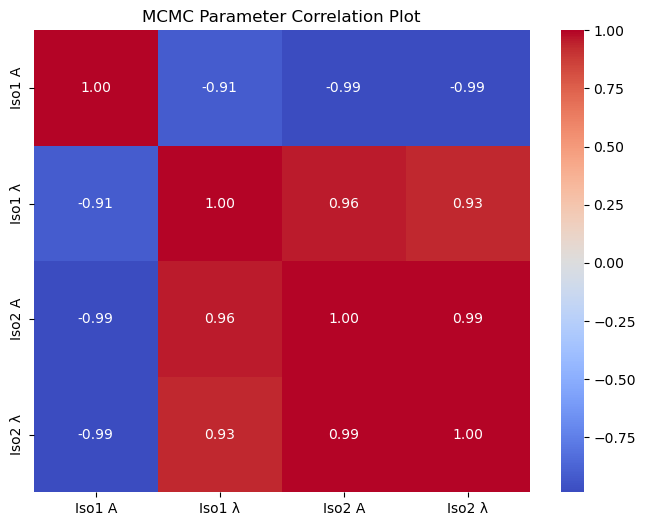

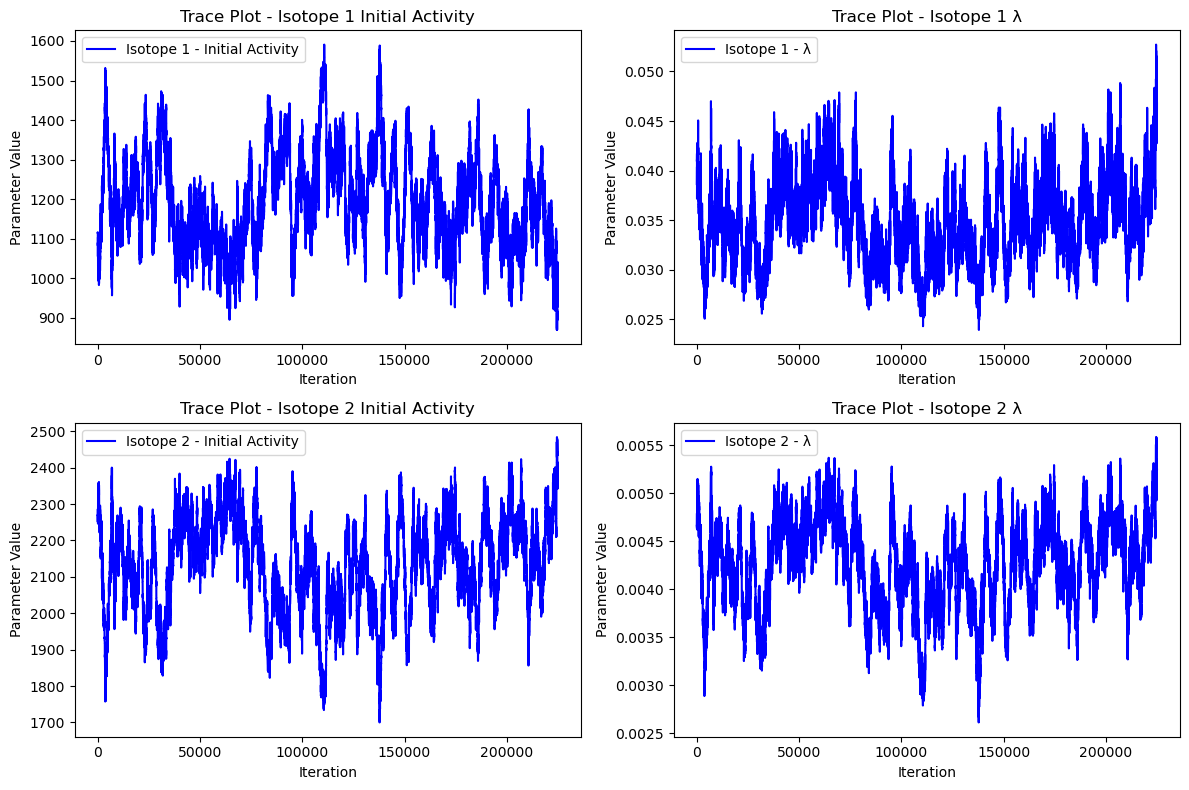

In [6]:
#MCMC Correlation and Trace plots
 
chain = chain1 

correlation_matrix = np.corrcoef(chain, rowvar=False)

plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=["Iso1 A", "Iso1 λ", "Iso2 A", "Iso2 λ"],
            yticklabels=["Iso1 A", "Iso1 λ", "Iso2 A", "Iso2 λ"])

plt.title("MCMC Parameter Correlation Plot")
plt.show()

plt.figure(figsize=(12, 8))

# Trace plot for Isotope 1 - Initial Activity
plt.subplot(2, 2, 1)
plt.plot(chain[:, 0], label='Isotope 1 - Initial Activity', color='blue')
plt.title('Trace Plot - Isotope 1 Initial Activity')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()

# Trace plot for Isotope 1 - λ
plt.subplot(2, 2, 2)
plt.plot(chain[:, 1], label='Isotope 1 - λ', color='blue')
plt.title('Trace Plot - Isotope 1 λ')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()

# Trace plot for Isotope 2 - Initial Activity
plt.subplot(2, 2, 3)
plt.plot(chain[:, 2], label='Isotope 2 - Initial Activity', color='blue')
plt.title('Trace Plot - Isotope 2 Initial Activity')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()

# Trace plot for Isotope 2 - λ
plt.subplot(2, 2, 4)
plt.plot(chain[:, 3], label='Isotope 2 - λ', color='blue')
plt.title('Trace Plot - Isotope 2 λ')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()

plt.tight_layout()
plt.show()

A correlation plot is shown for the model parameters in the dual isotope model, indicating significant correlation or anti-correlation between all parameters. Trace plots for parameters sampled by the MCMC chain are also shown.

In [7]:
#PRINT STATEMENTS, MIN CHI2 FOR EACH DATASET WITH CORRESPONDING M AND C - ONE ISOTOPE
print('ONE ISOTOPE - BEST FIT PARAMETERS (GRID METHOD)')
print('Grid 1: Chi Squared = ' + str(min_chi2_1))
print('Grid 1: Gradient/Decay Constant = ' + str(np.abs(m1_list[m1_index])) + ' ' + u"\u00B1" + ' ' + str(m1_unc))
print('Grid 1: Intercept = ' + str(c1_list[c1_index]) + ' ' + u"\u00B1" + ' ' + str(c1_unc))
print('Grid 1: Initial Activity = ' + str(np.exp(c1_list[c1_index])) + ' ' + u"\u00B1" + ' ' + str(np.exp(c1_list[c1_index])*c1_unc))

ONE ISOTOPE - BEST FIT PARAMETERS (GRID METHOD)
Grid 1: Chi Squared = 683.8041127946236
Grid 1: Gradient/Decay Constant = 0.007539038449460086 ± 9.189831106671317e-05
Grid 1: Intercept = 8.001823726724735 ± 0.005907231052413309
Grid 1: Initial Activity = 2986.399400105053 ± 17.641351271209043


These are the best fit parameters found using the chi-squared grid method for the single isotope model. The chi-squared statistic is also shown.

In [8]:
#PRINT STATEMENTS FOR ONE ISOTOPE FIT HALF LIVES
print('ONE ISOTOPE - HALF LIVES')
print('Dataset 1: Half Life = ' + str(t_half1) + ' ' + u"\u00B1" + ' ' + str(t_half_unc1))

ONE ISOTOPE - HALF LIVES
Dataset 1: Half Life = 91.94105922215924 ± 1.120730198796928


This is the half life calculated from the decay constant used in the single isotope model.

In [9]:
#PRINT STATEMENTS BEST FIT PARAMETERS FOR TWO ISOTOPE FIT
print('TWO ISOTOPE - FIT PARAMETERS FROM SCIPY')
print('Dataset 1: Initial Activity - Isotope 1 = ' + str(A1_1))
print('Dataset 1: Decay Constant - Isotope 1 = ' + str(lambda1_1))
print('Dataset 1: Initial Activity - Isotope 2 = ' + str(A2_1))
print('Dataset 1: Decay Constant - Isotope 2 = ' + str(lambda2_1))
print('Dataset 1: Chi Squared = ' + str(chi2_two_isotope1))

TWO ISOTOPE - FIT PARAMETERS FROM SCIPY
Dataset 1: Initial Activity - Isotope 1 = 1160.8262445140213
Dataset 1: Decay Constant - Isotope 1 = 0.03538231070446729
Dataset 1: Initial Activity - Isotope 2 = 2166.352319383459
Dataset 1: Decay Constant - Isotope 2 = 0.0043858144789574085
Dataset 1: Chi Squared = 114.80448269268376


These are the best fit parameters used in the dual isotope model using scipy.optimize.curve_fit. The chi-squared statistic is also shown.

In [19]:
#PRINT STATEMENTS FOR MCMC
print('TWO ISOTOPE - BEST FIT PARAMETERS FROM MCMC, median and 16 - 84% CI')
print('Dataset 1: Isotope 1 Median Decay Constant = ' + str(isotope1_mcmc_m1) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_m1))
print('Dataset 1: Isotope 1 Median Initial Activity = ' + str(isotope1_mcmc_c1) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_c1))
print('Dataset 1: Isotope 2 Median Decay Constant = ' + str(isotope2_mcmc_m1) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_m1))
print('Dataset 1: Isotope 2 Median Initial Activity = ' + str(isotope2_mcmc_c1) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_c1))
print('Dataset 1: Dual Isotope (MCMC) Chi squared value = ' + str(mcmc_chi2_min1))

TWO ISOTOPE - BEST FIT PARAMETERS FROM MCMC, median and 16 - 84% CI
Dataset 1: Isotope 1 Median Decay Constant = 0.034727864401715346 ± [0.0041304761547335846, 0.0044408867583133685]
Dataset 1: Isotope 1 Median Initial Activity = 1180.7664812992434 ± [105.72258498217525, 135.94522533721738]
Dataset 1: Isotope 2 Median Decay Constant = 0.004309300857740334 ± [0.0005361831940218168, 0.00042762079947407643]
Dataset 1: Isotope 2 Median Initial Activity = 2145.5178117597166 ± [148.5403618817636, 117.52278757165323]
Dataset 1: Dual Isotope (MCMC) Chi squared value = 114.84072464158734


These are the best fit parameters obtained using the MCMC method for the dual isotope model with uncertainties. The chi squared statistic for the model is also shown. This chi squared value is similar to the one obtained from scipy.optimize.curve_fit.

In [11]:
#TWO ISOTOPE - HALF LIVES
print('TWO ISOTOPE - HALF LIVES')
print('Dataset 1: Isotope 1 Half Life = ' + str(iso1_t_half1) + ' ' + u"\u00B1" + ' ' + str(iso1_t_half_unc1)) 
print('Dataset 1: Isotope 2 Half Life = ' + str(iso2_t_half1) + ' ' + u"\u00B1" + ' ' + str(iso2_t_half_unc1)) 

TWO ISOTOPE - HALF LIVES
Dataset 1: Isotope 1 Half Life = 19.959395502756802 ± [2.37393829 2.55234282]
Dataset 1: Isotope 2 Half Life = 160.84910370435603 ± [20.01359131 15.96138784]


These are the half lives determined from the decay constants obtained from the MCMC method.

In [12]:
#IDENTIFYING ISOTOPES
#Determined by subtracting calculated half life from known isotope half lives and finding the smallest difference. 
half_life_listnames = np.array(['Cesium_120', 'Cesium_121', 'Cesium_124', 'Barium_123', 'Barium_124', 'Barium_125', 'Barium_137', 'Europium_137', 'Europium_138', 'Europium_139', 'Europium_143', 'Tungsten_166', 'Tungsten_168', 'Tungsten_169', 'Neptunium_229', 'Neptunium_230', 'Neptunium_232'])
half_life_list = np.array([Cs_120, Cs_121, Cs_124, Ba_123, Ba_124, Ba_125, Ba_137, Eu_137, Eu_138, Eu_139, Eu_143, W_166, W_168, W_169, Np_229, Np_230, Np_232])

dataset_half_life1 = iso1_t_half1 #change to iso1_t_half2, 3 or 4 to identify isotopes using half lives from other datasets, currently set to dataset 1
dataset_half_life2 = iso2_t_half1 #change to iso2_t_half2, 3 or 4 to identify isotopes using half lives from other datasets, currently set to dataset 1

diff_list_iso1 = []
diff_list_iso2 = []

for i in half_life_list:
    half_life_diff = np.abs(dataset_half_life1 - i)
    diff_list_iso1.append(half_life_diff)

for i in half_life_list:
    half_life_diff = np.abs(dataset_half_life2 - i)
    diff_list_iso2.append(half_life_diff)

isotope1_index = diff_list_iso1.index(min(diff_list_iso1))
isotope1_half_life = half_life_list[isotope1_index]
isotope1_identity = half_life_listnames[isotope1_index]

isotope2_index = diff_list_iso2.index(min(diff_list_iso2))
isotope2_half_life = half_life_list[isotope2_index]
isotope2_identity = half_life_listnames[isotope2_index]

print('Isotope 1 = ' + ' ' + isotope1_identity)
print('Isotope 1 half life = ' + ' ' + str(isotope1_half_life))
print('Isotope 2 = ' + ' ' + isotope2_identity)
print('Isotope 2 half life = ' + ' ' + str(isotope2_half_life))

Isotope 1 =  Tungsten_166
Isotope 1 half life =  19.2
Isotope 2 =  Barium_123
Isotope 2 half life =  162.0


These are the isotopes identified from the half lives of both isotopes in the dual isotope model. This information needs to be interpreted with caution given that model parameters are highly correlated.

In [13]:
#PRINT STATEMENTS REDUCED CHI2, AIC, AIC_CORR AND BIC
print('CHI SQUARED, AIC, BIC COMPARISON BETWEEN ONE AND TWO ISOTOPE FITS')
print('Dataset 1: Chi Squared one isotope = ' + str(chi2_1))
print('Dataset 1: Chi Squared two isotope = ' + str(mcmc_chi2_min1))
print('Dataset 1: Reduced Chi2 for one isotope = ' + str(chi_reduced_1))
print('Dataset 1: Reduced Chi2 for two isotope = ' + str(two_isotope_chi_reduced_1))
print('Dataset 1: AIC for one isotope = ' + str(AIC_1))
print('Dataset 1: AIC for two isotope = ' + str(two_isotope_AIC_1))
print('Dataset 1: AIC corrected for one isotope = ' + str(AIC_corr_1)) 
print('Dataset 1: AIC corrected for two isotope = ' + str(two_isotope_AIC_corr_1))
print('Dataset 1: BIC for one isotope = ' + str(BIC_1))
print('Dataset 1: BIC for two isotope = ' + str(two_isotope_BIC_1))

CHI SQUARED, AIC, BIC COMPARISON BETWEEN ONE AND TWO ISOTOPE FITS
Dataset 1: Chi Squared one isotope = 683.7185408947028
Dataset 1: Chi Squared two isotope = 114.84072464158734
Dataset 1: Reduced Chi2 for one isotope = 6.977592987700241
Dataset 1: Reduced Chi2 for two isotope = 1.196257548349868
Dataset 1: AIC for one isotope = 687.8041127946236
Dataset 1: AIC for two isotope = 122.84072464158734
Dataset 1: AIC corrected for one isotope = 687.9278241348298
Dataset 1: AIC corrected for two isotope = 123.26177727316629
Dataset 1: BIC for one isotope = 693.0144531665998
Dataset 1: BIC for two isotope = 133.26140538553972


These are the comparisons of chi squared value, AIC and BIC values between the single and dual isotope models. The dual isotope model appears to provide a significantly better fit.

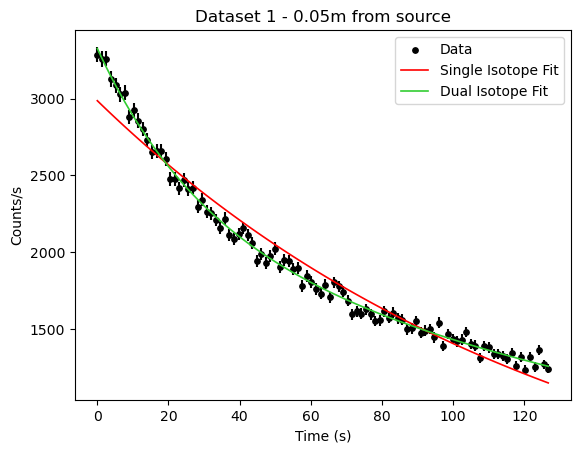

In [14]:
#PLOTS - Exponential fits to Counts vs Time - One and Two Isotope Models
# # Plot for Dataset 1
plt.scatter(x_data, y1_raw, s=15, color='black', label='Data')
plt.errorbar(x_data, y1_raw, y1_error_raw, linestyle='', color='black')
plt.plot(x_data, one_isotope_fit1, color='red', linewidth=1.2, label = 'Single Isotope Fit')
plt.plot(x_data, mcmc_fit1, color='limegreen', linewidth=1.2, label = 'Dual Isotope Fit')
plt.xlabel('Time (s)')
plt.ylabel('Counts/s')
plt.title('Dataset 1 - 0.05m from source')
plt.legend(loc='upper right')

Both model fits applied to the data.

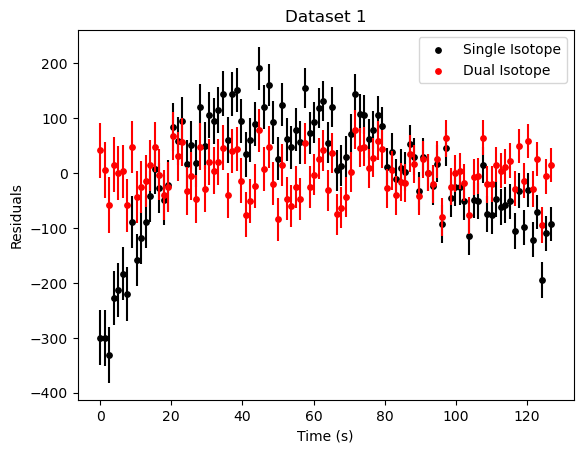

In [15]:
#RESIDUAL PLOTS
# Plot for Dataset 1
plt.scatter(x_data, one_isotope_res1, s=15, color='black', label = 'Single Isotope')
plt.errorbar(x_data, one_isotope_res1, y1_error_raw, linestyle='', color='black')
plt.scatter(x_data, two_isotope_res1, s=15, color='red', label = 'Dual Isotope')
plt.errorbar(x_data, two_isotope_res1, y1_error_raw, linestyle='', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Residuals')
plt.title('Dataset 1')
plt.legend(loc='upper right')

Residuals from the single isotope model indicate a trend in the data is being missed. Even scattering of residuals around 0 for the dual isotope model indicate a good fit to the data.

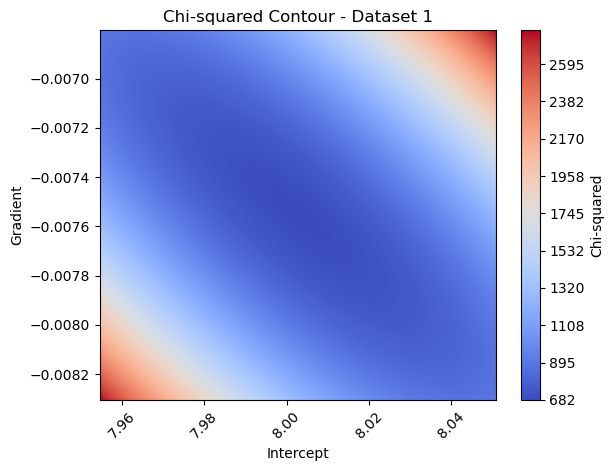

In [16]:
# #GRID PLOTS - Uncertainties in Parameters for One Isotope Fit
# Plot for Dataset 1
contour1 = plt.contourf(c1_list, m1_list, chi2_grid1, levels=1000, cmap='coolwarm')
plt.xlabel('Intercept')
plt.ylabel('Gradient')
plt.title('Chi-squared Contour - Dataset 1')
plt.colorbar(contour1, label='Chi-squared')
plt.tick_params(axis='x', rotation=45)  

Chi squared grid for the single isotope model

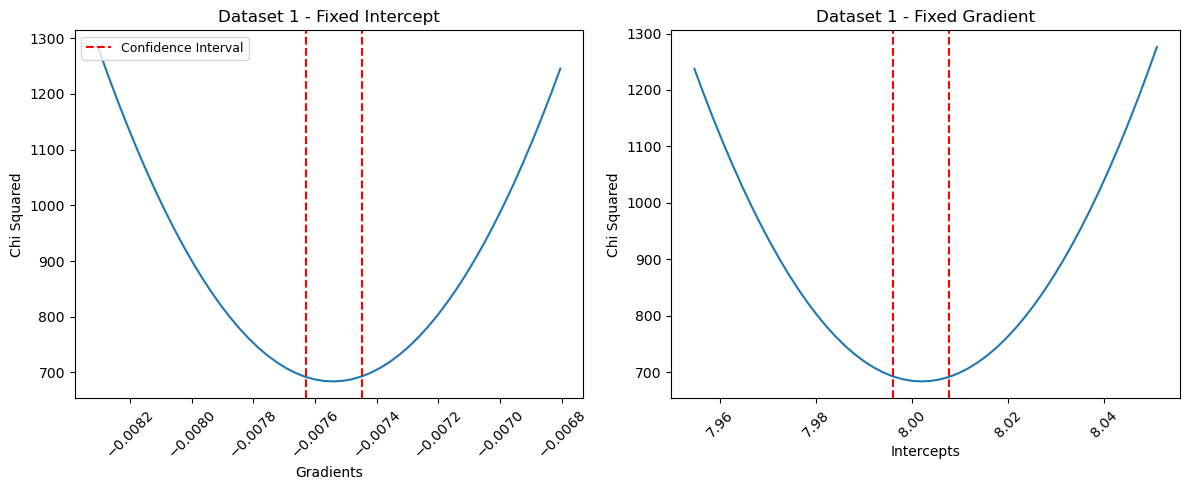

In [17]:
#CHI2 WITH ONE PARAMETER FIXED - One Isotope
# Dataset 1
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot 1
axs[0].plot(varying_m1, chi2_varying_m1)
axs[0].axvline(x=(best_fit_m1 - m1_unc), color='red', linestyle='dashed', label='Confidence Interval')
axs[0].axvline(x=(best_fit_m1 + m1_unc), color='red', linestyle='dashed', label='')
axs[0].set_xlabel('Gradients')
axs[0].set_ylabel('Chi Squared')
axs[0].set_title('Dataset 1 - Fixed Intercept')
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend(loc='upper left', fontsize=9)

# Plot 2
axs[1].plot(varying_c1, chi2_varying_c1)
axs[1].axvline(x=(best_fit_c1 - c1_unc), color='red', linestyle='dashed', label='')
axs[1].axvline(x=(best_fit_c1 + c1_unc), color='red', linestyle='dashed', label='')
axs[1].set_xlabel('Intercepts')
axs[1].set_ylabel('Chi Squared')
axs[1].set_title('Dataset 1 - Fixed Gradient')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Fixing one parameter in the single isotope model and varying the other to see the change in chi-squared value. The red dashed lines indicate the change in parameter causing change of 11.8 in chi squared value. The range between red dashed lines is the 99% confidence interval for the corresponding parameter. These give the uncertainties in best fit parameter for the single isotope model.

<Figure size 640x480 with 0 Axes>

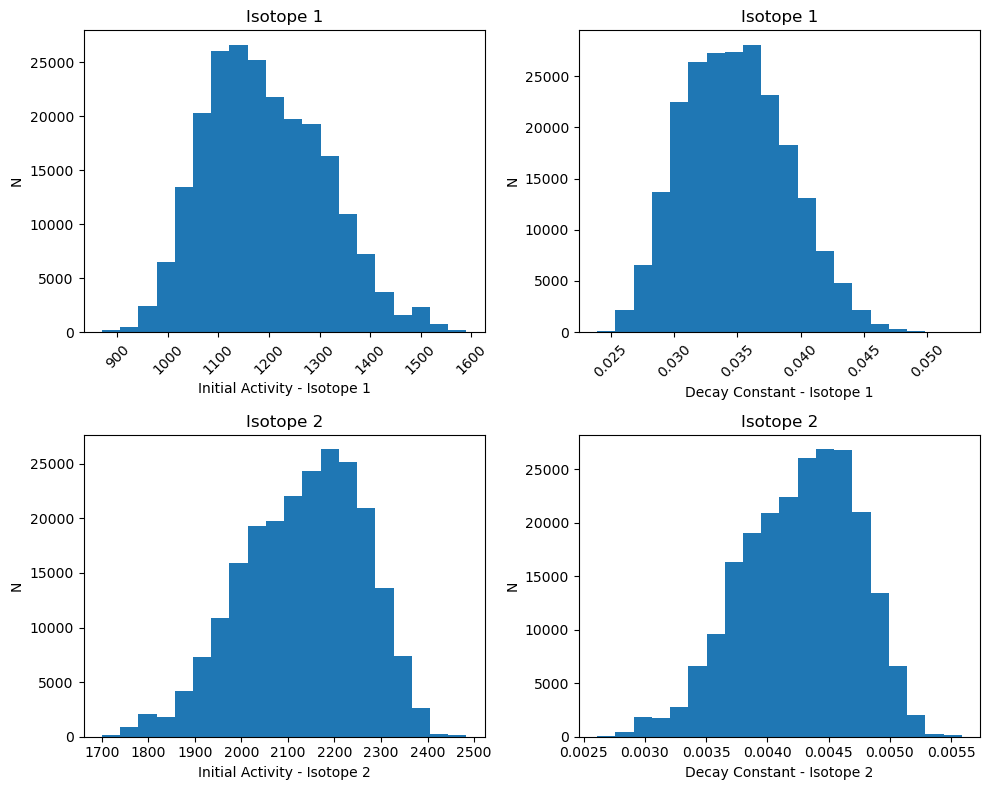

In [18]:
#Histograms for sampled parameters from MCMC

chain = chain1 #Chain from Dataset 1 - change chain1 to chain2, 3 or 4 for other datasets

plt.figure(2)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

#Plot for Dataset 1
axs[0, 0].hist(chain[:, 0], bins = 20)
axs[0, 0].set_xlabel('Initial Activity - Isotope 1')
axs[0, 0].set_ylabel('N')
axs[0, 0].set_title('Isotope 1')
axs[0, 0].tick_params(axis='x', rotation=45)  

# Plot for Dataset 2
axs[0, 1].hist(chain[:, 1], bins = 20)
axs[0, 1].set_xlabel('Decay Constant - Isotope 1')
axs[0, 1].set_ylabel('N')
axs[0, 1].set_title('Isotope 1')
axs[0, 1].tick_params(axis='x', rotation=45)  

# Plot for Dataset 3
axs[1, 0].hist(chain[:, 2], bins = 20)
axs[1, 0].set_xlabel('Initial Activity - Isotope 2')
axs[1, 0].set_ylabel('N')
axs[1, 0].set_title('Isotope 2')

# Plot for Dataset 4
axs[1, 1].hist(chain[:, 3], bins = 20)
axs[1, 1].set_xlabel('Decay Constant - Isotope 2')
axs[1, 1].set_ylabel('N')
axs[1, 1].set_title('Isotope 2')

plt.tight_layout()

Parameters sampled by the MCMC chain for the dual isotope model displayed as a histogram. As the distribution is not Gaussian, the mean and standard deviation will not provide an accurate representation of best fit parameter and uncertainty. The median and 16-84% confidence interval was therefore used instead.